In [8]:
# Loading modules required for data manipulation an EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading modules required for modelling
from sklearn.preprocessing import PolynomialFeatures    # TO create polynomial features
from sklearn.linear_model import LinearRegression       # To access the linear regresssor
from sklearn.model_selection import KFold               # To create training/testing sets
from sklearn.model_selection import GridSearchCV        # To creat a tuning grid for hyperparameters
from sklearn.decomposition import PCA                   # Feature selection tool
from sklearn.pipeline import make_pipeline              # Lets us build a pipeline

# Loading modules to assess error
from sklearn.metrics import mean_squared_error          # To measure residual variance from line of best fit

# loading modules to assess model
from sklearn.model_selection import cross_val_score     # To determine the model's cross validation accuracy scores
from sklearn.metrics import accuracy_score              # To determine the model's accuracy
from sklearn.dummy import DummyRegressor                # To create a regressor baseline

# Loading modules to plot confusion matrix
import matplotlib.pyplot as plt                         # This one
import seaborn as sns                                   # ... and this one are used to create figure objects
from sklearn.metrics import confusion_matrix            # To create confusion matrix
%matplotlib inline

In [3]:
# Importing Data
features = pd.read_csv('predictors.csv')
target = pd.read_csv('target.csv')

In [10]:
# Creating numpy arrays of data to get k-folds 
X = np.array(features)
y = np.array(target)
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
print('Number of splits: ', kf.get_n_splits(X))

# assigning the training and testing sets data based on the splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Returning array back to Dataframe
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

# Assessing sets
print('Dataset shapes: ', features.shape, "and ", target.shape)
print('Training set shape: ', X_train.shape, "and", y_train.shape)
print('Testing set shape: ', X_test.shape, "and ", y_test.shape)

Number of splits:  5
Dataset shapes:  (273, 30) and  (273, 1)
Training set shape:  (219, 30) and (219, 1)
Testing set shape:  (54, 30) and  (54, 1)


In [11]:
# Creating naive baseline to compare with
# baseline = np.mean(y) 
# y_baseline = np.repeat(baseline, len(y_test))
baseline = np.mean(y_train.iloc[:, 0].to_numpy())
y_baseline = np.repeat(baseline, len(y_test.iloc[:, 0].to_numpy()))
naive_RSME = mean_squared_error(y_test, y_baseline)
naive_RSME = np.sqrt(naive_RSME)

    # Creating a DummyRegressor baseline
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = dummy_mean.predict(X_test)
dummy_RSME = mean_squared_error(y_test, y_predict_dummy_mean)
dummy_RSME = np.sqrt(dummy_RSME)

In [12]:
# Creating polynomial features
poly = PolynomialFeatures(degree = 2, include_bias = False)
poly_features = poly.fit_transform(X)

# Building the model
model_lr = LinearRegression() 
print("Before optimization with tuning: ", model_lr.get_params())

Before optimization with tuning:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


In [13]:
# Building the model on training data
model_lr.fit(X_train, y_train.iloc[:, 0].to_numpy())

LinearRegression()

In [7]:
# Testing the model on training and on testing sets
preds_train_untuned_lr = model_lr.predict(X_train)
preds_test_untuned_lr = model_lr.predict(X_test)

# Measuring RMSE
RMSE_training_preds = np.sqrt(mean_squared_error(y_train, preds_train_untuned_lr))
RMSE_testing_preds = np.sqrt(mean_squared_error(y_test, preds_test_untuned_lr))

print('\nThe naive RMSE baseline is ', naive_RSME)
print('The dummy regressor RMSE baseline is ', dummy_RSME)
print('SVR Model performance on training set (RMSE)', RMSE_training_preds)
print('SVR Model performance on testing set(RMSE)  ', RMSE_testing_preds)


The naive RMSE baseline is  32895.59839540264
The dummy regressor RMSE baseline is  32895.59839540264
SVR Model performance on training set (RMSE) 17585.05826823859
SVR Model performance on testing set(RMSE)   22310.389467172325


In [8]:
# Creating model with feature selection (PCA)
pca = PCA(whiten = True,                                # Using uncorrelated components
          random_state = 42)                            # Setting a seed

model_pca_lr = make_pipeline(pca, model_lr)

param_lr = {"pca__n_components": [1, 3, 5]}

# Tuning hyperparameters
tuned_lr = GridSearchCV(model_pca_lr, param_lr, cv = 5)

# Deteriming cross fold validation scores
def average(lst):
    return sum(lst) / len(lst)
score_tuned_rf = cross_val_score(tuned_lr, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (tuned): ", score_tuned_rf, "\nCV score = ", average(score_tuned_rf)) 

# Trainning model on training data
tuned_lr.fit(X_train, y_train.iloc[:, 0].to_numpy())
print("\nFeatures selected by PCA:")
print(tuned_lr.best_params_)

# Testing model on training and testing set
pca_train_untuned_prediction = tuned_lr.predict(X_train)
pca_test_untuned_prediction = tuned_lr.predict(X_test)

# Measuring RMSE 
RMSE_training_preds_pca = np.sqrt(mean_squared_error(y_train, pca_train_untuned_prediction))
RMSE_testing_preds_pca = np.sqrt(mean_squared_error(y_test, pca_test_untuned_prediction))

print('\nThe naive RMSE baseline is ', naive_RSME)
print('The dummy regressor RMSE baseline is ', dummy_RSME)
print('SVR Model performance on training set (RMSE)', RMSE_training_preds_pca)
print('SVR Model performance on testing set(RMSE)  ', RMSE_testing_preds_pca)

Cross Validation scores (tuned):  [-0.59802018 -0.0375886  -0.14372609 -0.18360654 -5.56498157] 
CV score =  -1.3055845968189042

Features selected by PCA:
{'pca__n_components': 1}

The naive RMSE baseline is  32895.59839540264
The dummy regressor RMSE baseline is  32895.59839540264
SVR Model performance on training set (RMSE) 30413.512223412305
SVR Model performance on testing set(RMSE)   31098.204014433817


Text(0, 0.5, 'Fitted values')

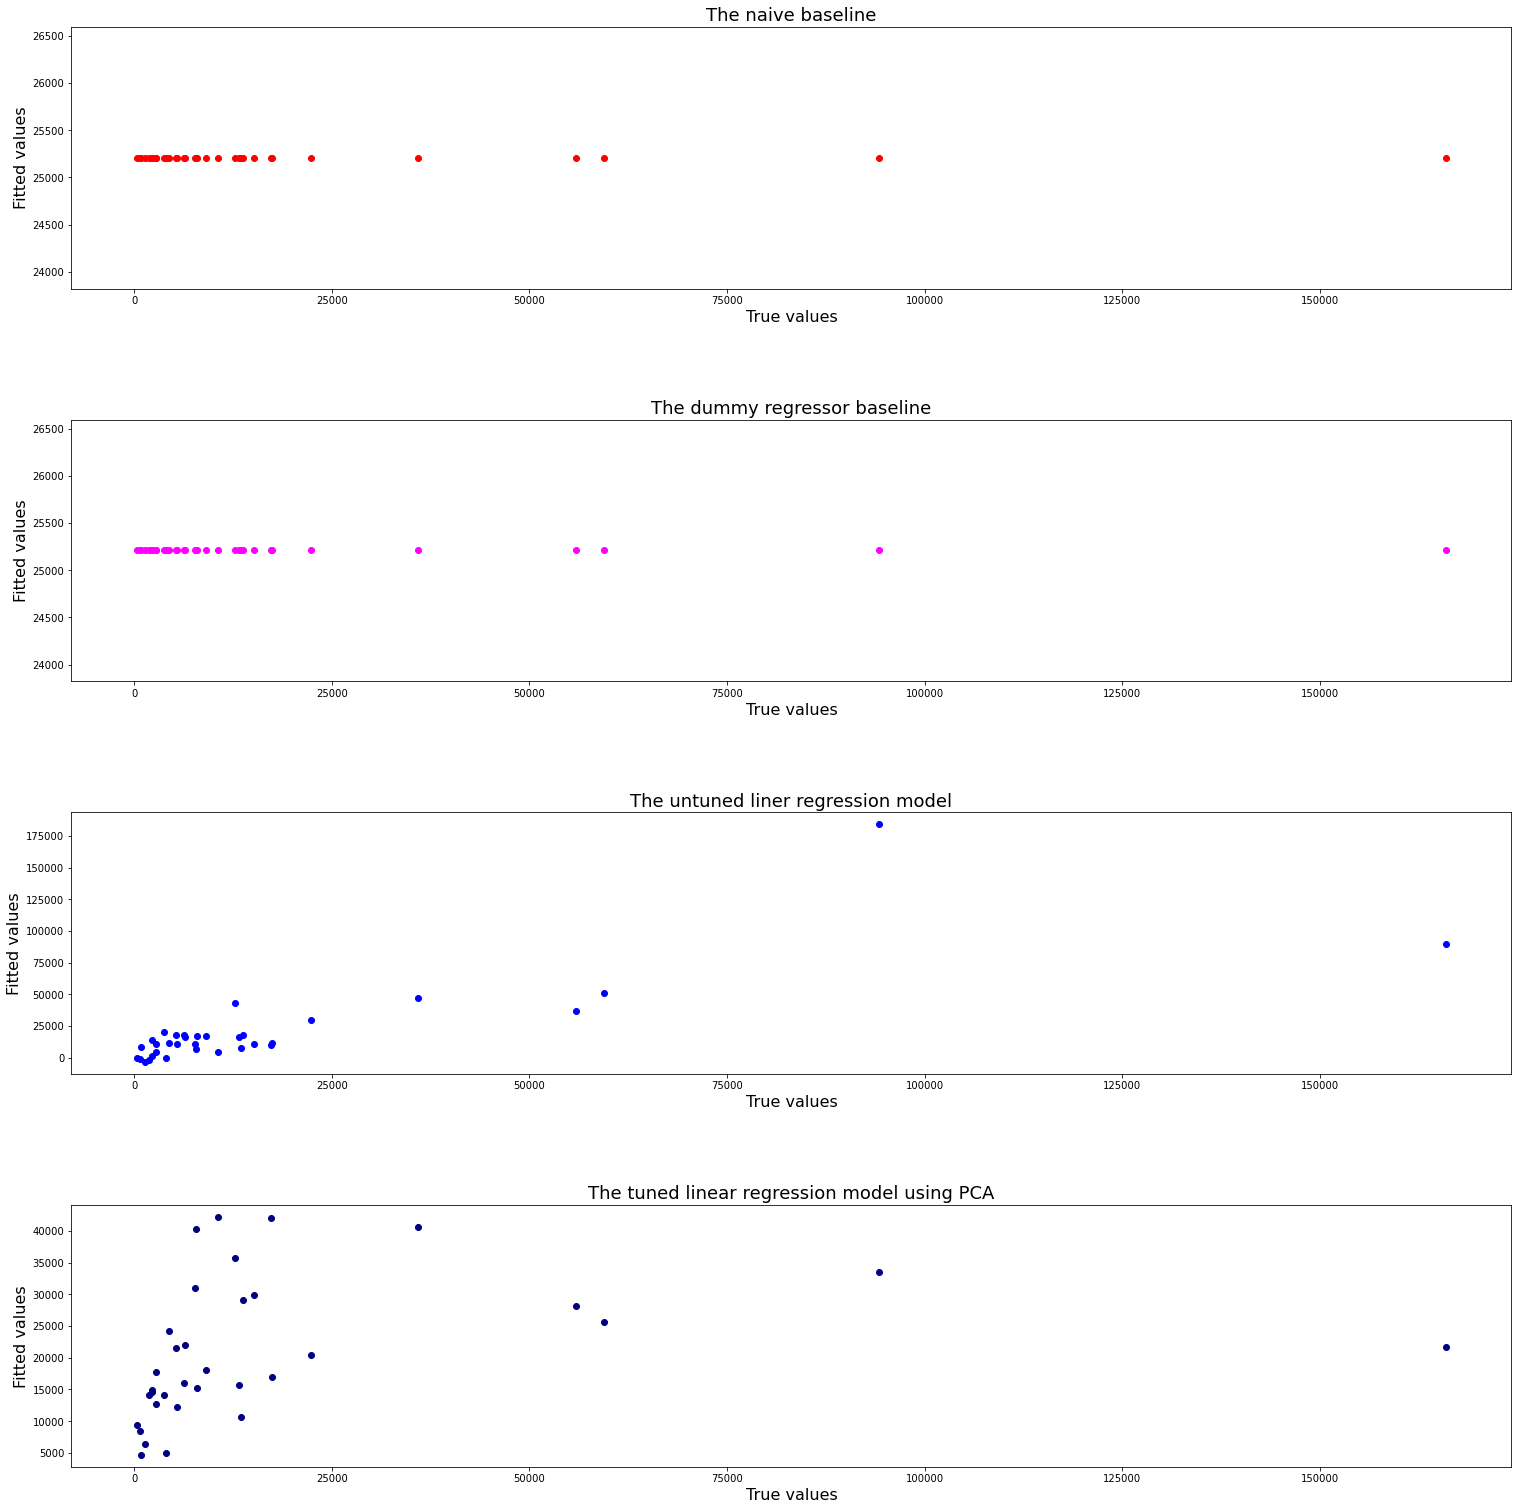

In [9]:
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust( left = 0, right = 1, bottom = 0, top = 1, hspace =0.5, wspace = 0.5)

ax = fig.add_subplot(4,1, 1)
plt.scatter(y_test, y_baseline, color = 'red')
#plt.plot(range(0,3000), range(0,3000),  color = 'green')
plt.title("The naive baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(4,1, 2)
plt.scatter(y_test, y_predict_dummy_mean, color = 'magenta')
#plt.plot(range(0,3000), range(0,3000),  color = 'green')
plt.title("The dummy regressor baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)


ax = fig.add_subplot(4,1, 3)
plt.scatter(y_test, preds_test_untuned_lr, color = 'blue')
#plt.plot(range(0,3000), range(0,3000),  color = 'green')
plt.title("The untuned liner regression model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(4,1, 4)
plt.scatter(y_test, pca_test_untuned_prediction, color = 'navy')
#plt.plot(range(0,3000), range(0,3000),  color = 'green')
plt.title("The tuned linear regression model using PCA", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)